<a href="https://colab.research.google.com/github/wskok2/AI-and-ML/blob/master/Traffic_Management.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install python-geohash

In [0]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
%matplotlib inline
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime as dt
import time
import geohash as gh
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.cluster import OPTICS

###Keras declaration

In [0]:
#Keras tensorflow declare
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

###Hyper Parameter

In [0]:
shift_days = 2
shift_steps = shift_days * 24 * 4
train_split = 0.9
batch_size = 32
sequence_length = 4 * 24 * 14
warmup_steps = 50

###Shape input function


In [0]:
def shape_input(df):
    
    
    #insert index
    df['inx'] = df['day'] +' ' +df['timestamp']
    df['inx']=pd.to_datetime(df['inx'], format='%j %H:%M', errors='coerce')
    
    
    df.drop(['day','timestamp'], axis=1)
    
    geoloc = df['geohash6'].unique().tolist()
    
    #decode lat long
    dgeo=pd.DataFrame(df['geohash6'].apply(lambda x: gh.decode(x)).tolist(), index=df.index,columns={'lat','long'})
    
    #sort before insert to main dataframe
    df.sort_index(inplace=True)
    dgeo.sort_index(inplace=True)
    
    #insert the lat long to main pd frame
    df.insert(1,'lat',dgeo['lat'])
    df.insert(2,'long',dgeo['long'])
    
    #drop string column day and timestamp
    df=df.drop(columns=['day','timestamp'])
    
    #set date as index 
    df.set_index(['geohash6','inx'], inplace=True)
    
    #transform into pivot like table
    dfgeoloc = [ df.xs(loc) for loc in geoloc ]     
    df = pd.concat(dfgeoloc, keys=geoloc,axis=1)
    
    #put back the day and timestamps
    df['extra','day'] = df.index.dayofyear
    df['extra','hour'] = df.index.hour
    df['extra','minute'] = df.index.minute
    
    #fill in blank
    for loc in geoloc:
        print(loc)
        df[loc]=df[loc].fillna(0)

        
    return dgeo, df  

###Lost Function

In [0]:
def loss_mse_warmup(y_true, y_pred):


    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]


    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

###Plotting Function

In [0]:
def plot_comparison(start_idx, length=100, train=True):

    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

###Batch generating function

In [0]:
def batch_generator(batch_size, sequence_length):

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        print(x_shape)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.

            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)    
    

##Main functions

In [0]:
df= pd.read_csv('training.csv',dtype={'geohash6' : str,'day':str, 'timestamp':str,'demand':float})

#temporary disable
dgeo, df = shape_input(df)



In [0]:
geoX=df['geohash6']

Target predictions

In [0]:
target_loc='qp03wc'
target_names=['demand']

In [0]:
df_targets = df[target_loc][target_names].shift(-shift_steps)


Prepare test and validation set

In [0]:
x_data = df.values[0:-shift_steps]
y_data = df_targets.values[:-shift_steps]

#Change the shape of tuple from (x,) to (x,1)

y_data.shape=(y_data.shape[0],1)

num_data=len(x_data)

num_train = int(train_split * num_data)
num_test = num_data - num_train


x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

num_x_signals = x_data.shape[1]
num_y_signals = 1

Scale data

In [0]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)


Generating batch

In [0]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)

validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))


(32, 1344, 3990)


RNN model

In [0]:

model = Sequential()
model.add(GRU(units=128,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

model.add(Dense(num_y_signals, activation='sigmoid'))

if False:
    from tensorflow.python.keras.initializers import RandomUniform

    # Maybe use lower init-ranges.
    init = RandomUniform(minval=-0.05, maxval=0.05)

    model.add(Dense(num_y_signals,
                    activation='linear',
                    kernel_initializer=init))

optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 128)         1512576   
_________________________________________________________________
dense (Dense)                (None, None, 1)           129       
Total params: 1,512,705
Trainable params: 1,512,705
Non-trainable params: 0
_________________________________________________________________


GPU version of RNN

In [0]:
with tf.device('/gpu:0'):
  
  model = Sequential()
  model.add(GRU(units=128,
                return_sequences=True,
                input_shape=(None, num_x_signals,)))

  model.add(Dense(num_y_signals, activation='sigmoid'))

  if False:
      from tensorflow.python.keras.initializers import RandomUniform

      # Maybe use lower init-ranges.
      init = RandomUniform(minval=-0.05, maxval=0.05)

      model.add(Dense(num_y_signals,
                      activation='linear',
                      kernel_initializer=init))

  optimizer = RMSprop(lr=1e-3)
  model.compile(loss=loss_mse_warmup, optimizer=optimizer)

  model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, None, 128)         1581696   
_________________________________________________________________
dense_3 (Dense)              (None, None, 1)           129       
Total params: 1,581,825
Trainable params: 1,581,825
Non-trainable params: 0
_________________________________________________________________


Call back

In [0]:
path_checkpoint = 'trafficdemand_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
                                       
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

Model training

In [0]:
print("Start Time: " + str(time.time()))
model.fit_generator(generator=generator,
                    epochs=5,
                    steps_per_epoch=50,
                    validation_data=validation_data,
                    callbacks=callbacks)      

try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)                          


Start Time: 1560397700.2830787
Epoch 1/5(32, 1344, 3990)

(32, 1344, 3990)
1/1 [==============================] - 0s 355ms/sample - loss: 0.1594

Epoch 00001: val_loss improved from inf to 0.15936, saving model to trafficdemand_checkpoint.keras
50/50 [==============================] - 274s 5s/step - loss: 0.1468 - val_loss: 0.1594
Epoch 2/5
(32, 1344, 3990)
1/1 [==============================] - 0s 248ms/sample - loss: 0.0518

Epoch 00002: val_loss improved from 0.15936 to 0.05185, saving model to trafficdemand_checkpoint.keras
50/50 [==============================] - 270s 5s/step - loss: 0.1380 - val_loss: 0.0518
Epoch 3/5
(32, 1344, 3990)
1/1 [==============================] - 0s 227ms/sample - loss: 0.0252

Epoch 00003: val_loss improved from 0.05185 to 0.02523, saving model to trafficdemand_checkpoint.keras
50/50 [==============================] - 270s 5s/step - loss: 0.0326 - val_loss: 0.0252
Epoch 4/5
(32, 1344, 3990)
1/1 [==============================] - 0s 228ms/sample - loss:

Validation

1/1 [==============================] - 0s 369ms/sample - loss: 0.0147
loss (test-set): 0.014692483469843864


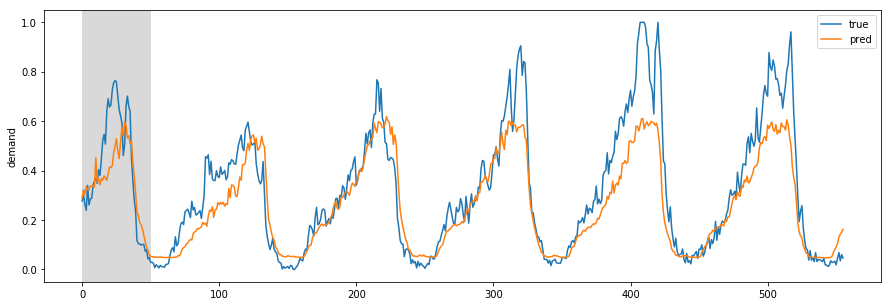

In [0]:
#Performance on test set
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))
print("loss (test-set):", result)

plot_comparison(start_idx=10, length=960, train=False)

In [0]:
#predict(x, batch_size=None, verbose=0, steps=None, callbacks=None)

x = x_train_scaled
y_true = y_train

x = np.expand_dims(x, axis=0)
x

array([[[0.        , 1.        , 0.05485798, ..., 0.        ,
         0.        , 0.        ],
        [0.        , 1.        , 0.08620924, ..., 0.        ,
         0.        , 0.33333333],
        [0.        , 1.        , 0.05073921, ..., 0.        ,
         0.        , 0.66666667],
        ...,
        [0.        , 1.        , 0.11911306, ..., 1.        ,
         0.04347826, 1.        ],
        [0.        , 1.        , 0.13947777, ..., 1.        ,
         0.08695652, 0.        ],
        [0.        , 1.        , 0.15842315, ..., 1.        ,
         0.08695652, 0.33333333]]])

In [0]:
y_pred = model.predict(x)
y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])

y_pred_rescaled

array([[0.02664465],
       [0.01736993],
       [0.01550019],
       ...,
       [0.01110308],
       [0.01146328],
       [0.01084023]], dtype=float32)

In [0]:
print(y_train)
print(y_true[:,0])
print(y_pred_rescaled[:,0])

[[0.2533157 ]
 [0.25419566]
 [0.26014047]
 ...
 [0.12623627]
 [0.13883799]
 [0.19021915]]
[0.2533157  0.25419566 0.26014047 ... 0.12623627 0.13883799 0.19021915]
[0.17961705 0.18149605 0.18630084 ... 0.10167597 0.11900426 0.13477384]
